In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import Model
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [3]:
# Constants
IMAGE_SIZE = 124
CHANNELS = 3

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well
TEST_SIZE = 0.3
ALPHA = 0.001
EPOCHS = 50 # number of cycles to run
PATIENCE = 10
LR_PATIENCE = 10
FACTOR_LR = 0.5
BATCH_SIZE = 32 # inline of Training Rows being 60000

params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,4),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params)

In [4]:
def fn_plot_hist(hist_df):

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [5]:
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brahmi3/English_Data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brahmi3/English_Data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE,
)

Found 70224 files belonging to 315 classes.
Using 49157 files for training.
Found 70224 files belonging to 315 classes.
Using 21067 files for validation.


In [6]:
class_names = train_ds.class_names

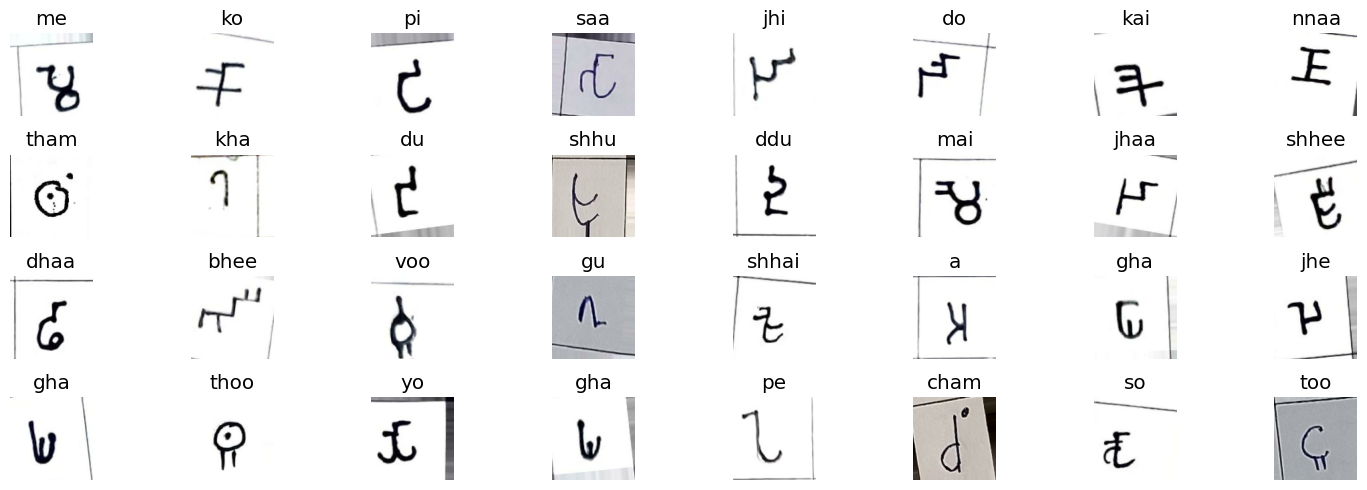

In [7]:
plt.figure(figsize=(15,5))

for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8), 8, i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i]])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [8]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, 315)))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, 315)))

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model
from keras.layers import Dropout
from keras.regularizers import l2

base_model = InceptionResNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE,  CHANNELS),  # Set channels to  1 for grayscale
                                include_top=False,
                                weights="imagenet", pooling='max')

# Build the new model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.3)(x)  # Add dropout with an optimal value of  0.3
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.3)(x)  # Add dropout with an optimal value of  0.3
predictions = Dense(315, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

219055592/219055592 [==============================] - 9s 0us/step


In [10]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True,
    verbose = 1)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)

In [11]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=ALPHA), metrics=['accuracy'])

In [12]:
from keras.utils import plot_model

# Assuming 'model' is your model

from IPython.display import FileLink

plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True, expand_nested=False)
# Create a download link for the image
FileLink('model_summary.png')

/kaggle/working/model_summary.png

In [13]:
history = model.fit(train_ds, validation_data=test_ds,
                    epochs=EPOCHS,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_callback, lr_decay]
                   )

Epoch 1/50


I0000 00:00:1708413030.074397     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1537/1537 [==============================] - 436s 199ms/step - loss: 1.8398 - accuracy: 0.6169 - val_loss: 0.2014 - val_accuracy: 0.9457 - lr: 0.0010
Epoch 2/50
1537/1537 [==============================] - 268s 174ms/step - loss: 0.2566 - accuracy: 0.9364 - val_loss: 0.1490 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 3/50
1537/1537 [==============================] - 268s 174ms/step - loss: 0.1762 - accuracy: 0.9527 - val_loss: 0.1205 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 4/50
1537/1537 [==============================] - 267s 174ms/step - loss: 0.1397 - accuracy: 0.9611 - val_loss: 0.1057 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 5/50
1537/1537 [==============================] - 265s 172ms/step - loss: 0.1152 - accuracy: 0.9684 - val_loss: 0.1229 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 6/50
1537/1537 [==============================] - 266s 173ms/step - loss: 0.0949 - accuracy: 0.9740 - val_loss: 0.3312 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 7/50
1537/1537 [=======================

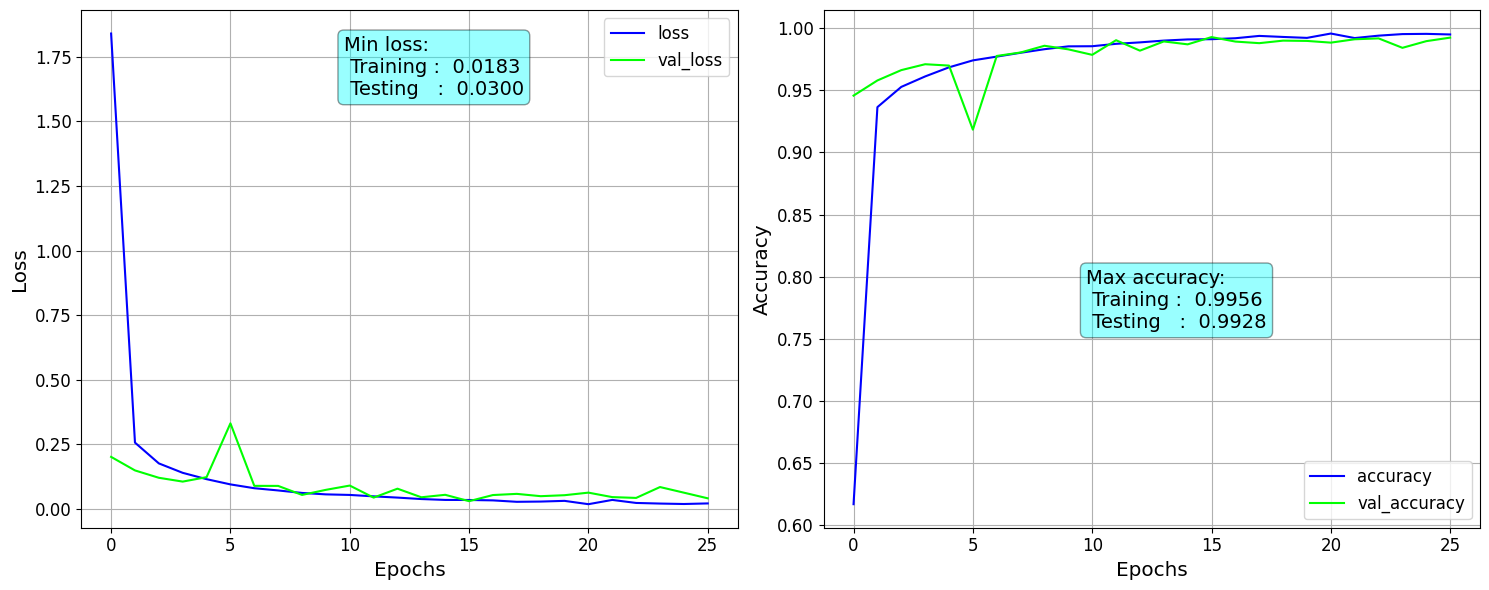

In [14]:
data = pd.DataFrame(history.history)
fn_plot_hist(data)

In [15]:
model.save("InceptionResNetV2(Updated).h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from tensorflow.keras.models import load_model

model = load_model("InceptionResNetV2(Updated).h5")

In [17]:
# Assuming 'dataset' is your tf.data.Dataset object that has been prefetched
first_element = test_ds.take(1)
image, label = next(iter(first_element))
label

<tf.Tensor: shape=(32, 315), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [18]:
pred = model.predict(image)
pred

1/1 [==============================] - 4s 4s/step


array([[6.4230717e-13, 2.8999602e-15, 5.3254549e-12, ..., 1.1956749e-15,
        2.9231744e-14, 6.5961640e-14],
       [2.3770931e-16, 6.5614194e-14, 8.0509297e-17, ..., 2.8168242e-15,
        8.3982591e-16, 3.4965242e-16],
       [1.0944378e-12, 2.6834118e-13, 1.7994426e-16, ..., 2.1077307e-15,
        3.1924675e-11, 8.9140106e-16],
       ...,
       [9.7314836e-15, 9.9921421e-14, 7.6768409e-12, ..., 1.0156363e-18,
        2.7999463e-16, 1.1253709e-16],
       [1.2950922e-10, 1.0411604e-09, 2.4995894e-11, ..., 4.8227047e-13,
        1.0497357e-15, 2.1908948e-14],
       [5.1151650e-10, 1.7073011e-10, 1.3539798e-15, ..., 3.1594167e-12,
        8.6073752e-15, 1.3650099e-12]], dtype=float32)

In [19]:
actual_class = np.argmax(label, axis=1)

# Now y_pred_class contains the predicted class labels
actual_class

array([299, 238, 292,  16, 267,  99, 263, 236, 253, 257, 286,  92,  85,
       114, 142, 180, 283, 195, 120, 134, 200, 266,  36, 178, 260, 130,
       244, 175, 114, 281,  38, 229])

In [20]:
# Assuming y_pred is your array of predicted probabilities
pred_class = np.argmax(pred, axis=1)

# Now y_pred_class contains the predicted class labels
pred_class

array([299, 238, 292,  16, 267,  99, 263, 236, 253, 257, 286,  92,  85,
       114, 142, 180, 283, 195, 120, 134, 200, 266,  36, 178, 260, 130,
       244, 175, 114, 281,  38, 229])

In [21]:
data = pd.DataFrame({"true":actual_class,"pred":pred_class})

In [22]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [23]:
print(classification_report(data['true'],data['pred']))

              precision    recall  f1-score   support

          16       1.00      1.00      1.00         1
          36       1.00      1.00      1.00         1
          38       1.00      1.00      1.00         1
          85       1.00      1.00      1.00         1
          92       1.00      1.00      1.00         1
          99       1.00      1.00      1.00         1
         114       1.00      1.00      1.00         2
         120       1.00      1.00      1.00         1
         130       1.00      1.00      1.00         1
         134       1.00      1.00      1.00         1
         142       1.00      1.00      1.00         1
         175       1.00      1.00      1.00         1
         178       1.00      1.00      1.00         1
         180       1.00      1.00      1.00         1
         195       1.00      1.00      1.00         1
         200       1.00      1.00      1.00         1
         229       1.00      1.00      1.00         1
         236       1.00    

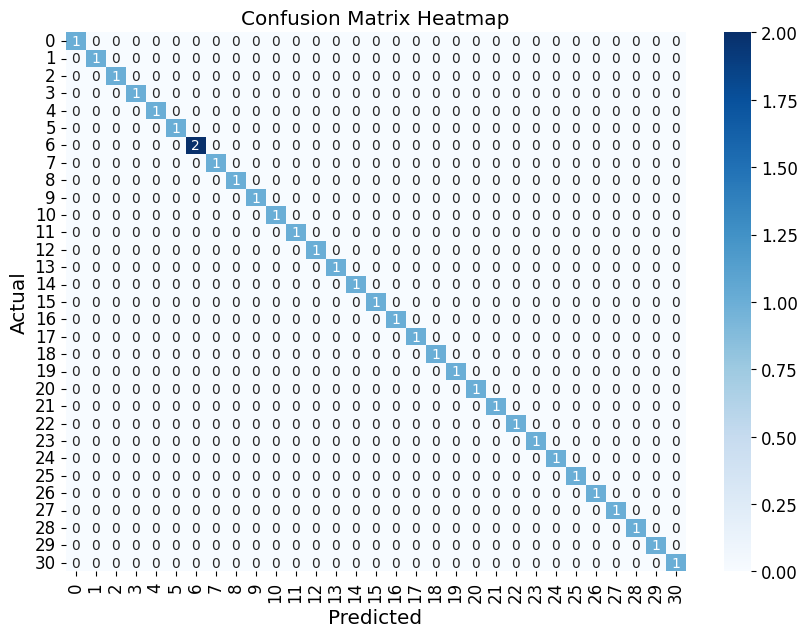

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' are your true labels and 'y_pred' are your predicted labels
conf_mat = confusion_matrix(data['true'],data['pred'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,  7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()
